In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

60000
torch.Size([1, 28, 28]) 5


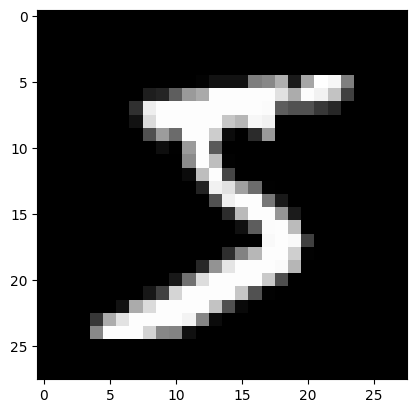

In [3]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [4]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [6]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 1)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

In [7]:
from torch.optim import SGD

lr = 0.001
model = model.to('cpu')

optimizer = SGD(model.parameters(), lr=lr)

In [8]:
n_epochs = 100

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cpu'), labels.to('cpu')

    preds = model(inputs)
    loss = (preds[:, 0] - labels).pow(2).mean()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 4577.447074890137
Epoch   1 | Loss: 2498.1938004493713
Epoch   2 | Loss: 1799.4786841273308
Epoch   3 | Loss: 1416.892346084118
Epoch   4 | Loss: 1197.5713847875595
Epoch   5 | Loss: 1057.757207930088
Epoch   6 | Loss: 960.3007908761501
Epoch   7 | Loss: 886.6396339833736
Epoch   8 | Loss: 830.8196381628513
Epoch   9 | Loss: 778.8518868088722
Epoch  10 | Loss: 736.882546722889
Epoch  11 | Loss: 701.4844193309546
Epoch  12 | Loss: 671.0511660426855
Epoch  13 | Loss: 639.5841284096241
Epoch  14 | Loss: 612.5557567924261
Epoch  15 | Loss: 590.2455698847771
Epoch  16 | Loss: 566.1125109344721
Epoch  17 | Loss: 547.464946269989
Epoch  18 | Loss: 532.4378670752048
Epoch  19 | Loss: 509.10103049874306
Epoch  20 | Loss: 496.5235512331128
Epoch  21 | Loss: 478.2869861423969
Epoch  22 | Loss: 464.36797623336315
Epoch  23 | Loss: 450.47452913224697
Epoch  24 | Loss: 435.9077348411083
Epoch  25 | Loss: 422.7414992377162
Epoch  26 | Loss: 413.40632778406143
Epoch  27 | Loss: 405.8

In [9]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cpu')

print(model(x))
print(trainset[idx][1])

tensor([[4.6354]], grad_fn=<ReluBackward0>)
5


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 256  
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False 
)

In [12]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)  

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) 

    return x

In [13]:
model = Model(28 * 28 * 1, 1024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# 학습률 설정
lr = 0.001
# 옵티마이저 설정
optimizer = SGD(model.parameters(), lr=lr)

# 손실 함수 설정 (CrossEntropyLoss)
criterion = CrossEntropyLoss()

In [15]:
import numpy as np

# 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  model.eval()  # 평가 모드로 설정
  with torch.no_grad():  # 그래디언트 계산 비활성화
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      preds = model(inputs)
      preds = torch.argmax(preds, dim=-1)

      cnt += labels.shape[0]
      acc += (labels == preds).sum().item()

  return acc / cnt

# 정확도 시각화 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.figure(figsize=(10, 6))
  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Test Accuracy over Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

In [16]:
# 학습 파라미터 설정
n_epochs = 100
batch_size = 256

# 학습 결과 저장용 리스트
train_accs = []
test_accs = []

# 학습 시작
for epoch in range(n_epochs):
  # 학습 모드
  model.train()
  total_loss = 0.0
  
  for data in trainloader:
    # 그래디언트 초기화
    optimizer.zero_grad()
    
    # 데이터 준비
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # 순전파
    outputs = model(inputs)
    
    # 손실 계산
    loss = criterion(outputs, labels)
    
    # 역전파 및 가중치 업데이트
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  # 매 에폭마다 정확도 측정
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)
  
  # 정확도 저장
  train_accs.append(train_acc)
  test_accs.append(test_acc)
  
  # 진행 상황 출력
  print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# 학습 완료 메시지
print("학습 완료!")

Epoch   1/100 | Loss: 2128.7768 | Train Acc: 0.5841 | Test Acc: 0.5922
Epoch   2/100 | Loss: 2057.4657 | Train Acc: 0.6943 | Test Acc: 0.7072
Epoch   3/100 | Loss: 1942.4813 | Train Acc: 0.7181 | Test Acc: 0.7226
Epoch   4/100 | Loss: 1743.0673 | Train Acc: 0.7302 | Test Acc: 0.7338
Epoch   5/100 | Loss: 1446.7859 | Train Acc: 0.7606 | Test Acc: 0.7675
Epoch   6/100 | Loss: 1138.7543 | Train Acc: 0.7909 | Test Acc: 0.8001
Epoch   7/100 | Loss: 910.0030 | Train Acc: 0.8120 | Test Acc: 0.8177
Epoch   8/100 | Loss: 760.4197 | Train Acc: 0.8305 | Test Acc: 0.8372
Epoch   9/100 | Loss: 660.9449 | Train Acc: 0.8396 | Test Acc: 0.8461
Epoch  10/100 | Loss: 591.4022 | Train Acc: 0.8504 | Test Acc: 0.8573
Epoch  11/100 | Loss: 540.4743 | Train Acc: 0.8598 | Test Acc: 0.8656
Epoch  12/100 | Loss: 501.6323 | Train Acc: 0.8666 | Test Acc: 0.8722
Epoch  13/100 | Loss: 471.1316 | Train Acc: 0.8718 | Test Acc: 0.8773
Epoch  14/100 | Loss: 446.6651 | Train Acc: 0.8773 | Test Acc: 0.8826
Epoch  15/100 

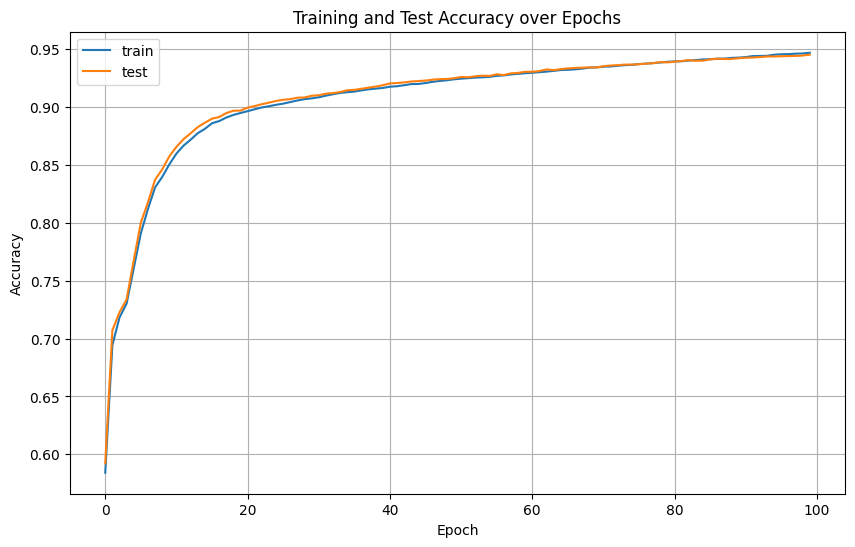

In [17]:
# 정확도 시각화
plot_acc(train_accs, test_accs)


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
훈련 데이터셋 크기: 50000
입력 이미지 shape: torch.Size([3, 32, 32]), 레이블: 6


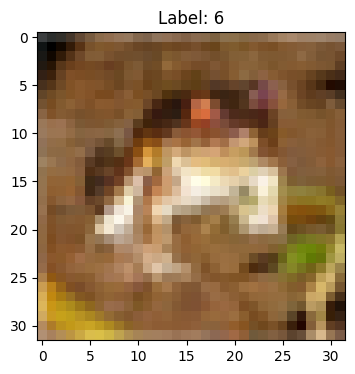

배치 이미지 shape: torch.Size([256, 3, 32, 32]), 배치 레이블 shape: torch.Size([256])


In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss

# 데이터셋 로드
transform = transforms.ToTensor()

# CIFAR10 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 데이터셋 크기 및 shape 확인
print(f"훈련 데이터셋 크기: {len(trainset)}")
print(f"입력 이미지 shape: {trainset[0][0].shape}, 레이블: {trainset[0][1]}")

# 이미지 시각화
plt.figure(figsize=(4, 4))
plt.imshow(trainset[0][0].permute(1, 2, 0))  # CIFAR10은 컬러 이미지이므로 채널 순서 변경
plt.title(f"Label: {trainset[0][1]}")
plt.show()

# 데이터로더 설정
batch_size = 256
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

# 배치 데이터 shape 확인
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"배치 이미지 shape: {images.shape}, 배치 레이블 shape: {labels.shape}")

In [19]:
# 기본 모델 정의 (LeakyReLU 사용)
class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)  # CIFAR10은 10개 클래스

        self.act = nn.LeakyReLU(0.1)  # LeakyReLU 사용

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)  # 마지막 레이어는 활성화 함수 없음

        return x

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")

사용 디바이스: cpu


In [20]:
# 정확도 측정 함수
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()  # 평가 모드로 설정
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

    return acc / cnt

# 정확도 시각화 함수
def plot_acc(accs_dict, title='Accuracy Comparison'):
    plt.figure(figsize=(10, 6))
    
    for label, accs in accs_dict.items():
        plt.plot(np.arange(len(accs)), accs, label=label)
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Training SGD Model...
Epoch   1/50 | Loss: 450.7055 | Train Acc: 0.1538
Epoch   5/50 | Loss: 442.6791 | Train Acc: 0.1697
Epoch  10/50 | Loss: 430.2315 | Train Acc: 0.2391
Epoch  15/50 | Loss: 414.9957 | Train Acc: 0.2687
Epoch  20/50 | Loss: 402.7774 | Train Acc: 0.2886
Epoch  25/50 | Loss: 393.8758 | Train Acc: 0.2950
Epoch  30/50 | Loss: 386.9869 | Train Acc: 0.3063
Epoch  35/50 | Loss: 381.4290 | Train Acc: 0.3170
Epoch  40/50 | Loss: 376.9405 | Train Acc: 0.3256
Epoch  45/50 | Loss: 373.1169 | Train Acc: 0.3327
Epoch  50/50 | Loss: 369.9195 | Train Acc: 0.3388
Training Adam Model...
Epoch   1/50 | Loss: 370.1507 | Train Acc: 0.3964
Epoch   5/50 | Loss: 290.9736 | Train Acc: 0.4766
Epoch  10/50 | Loss: 259.8117 | Train Acc: 0.5246
Epoch  15/50 | Loss: 234.7490 | Train Acc: 0.5827
Epoch  20/50 | Loss: 207.0745 | Train Acc: 0.6461
Epoch  25/50 | Loss: 183.1004 | Train Acc: 0.6409
Epoch  30/50 | Loss: 157.5038 | Train Acc: 0.7493
Epoch  35/50 | Loss: 131.6524 | Train Acc: 0.7691
Epoch

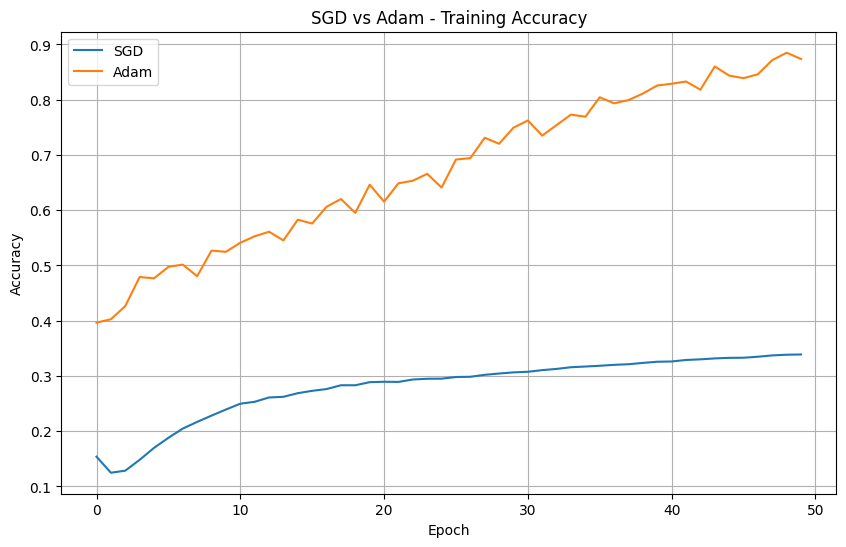

In [21]:
# 학습 함수 정의
def train_model(model, optimizer, n_epochs, trainloader, testloader, model_name="Model"):
    criterion = CrossEntropyLoss()
    train_accs = []
    
    print(f"Training {model_name}...")
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        
        for data in trainloader:
            optimizer.zero_grad()
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 매 에폭마다 정확도 측정
        train_acc = accuracy(model, trainloader)
        train_accs.append(train_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

    return train_accs

# 모델 초기화 및 학습 (SGD)
n_epochs = 50
input_dim = 32 * 32 * 3  # CIFAR10 이미지 크기

model_sgd = Model(input_dim, 1024).to(device)
optimizer_sgd = SGD(model_sgd.parameters(), lr=0.001)
train_accs_sgd = train_model(model_sgd, optimizer_sgd, n_epochs, trainloader, testloader, "SGD Model")

# 모델 초기화 및 학습 (Adam)
model_adam = Model(input_dim, 1024).to(device)
optimizer_adam = Adam(model_adam.parameters(), lr=0.001)
train_accs_adam = train_model(model_adam, optimizer_adam, n_epochs, trainloader, testloader, "Adam Model")

# 결과 시각화 (Plot 1)
plot_acc({'SGD': train_accs_sgd, 'Adam': train_accs_adam}, 'SGD vs Adam - Training Accuracy')

Training Sigmoid Model...
Epoch   1/50 | Loss: 384.7456 | Train Acc: 0.3528
Epoch   5/50 | Loss: 298.3497 | Train Acc: 0.4504
Epoch  10/50 | Loss: 270.0295 | Train Acc: 0.5037
Epoch  15/50 | Loss: 249.3224 | Train Acc: 0.5442
Epoch  20/50 | Loss: 230.5911 | Train Acc: 0.5963
Epoch  25/50 | Loss: 213.6922 | Train Acc: 0.6177
Epoch  30/50 | Loss: 196.4109 | Train Acc: 0.6464
Epoch  35/50 | Loss: 184.5616 | Train Acc: 0.6534
Epoch  40/50 | Loss: 166.8521 | Train Acc: 0.7026
Epoch  45/50 | Loss: 155.6935 | Train Acc: 0.7222
Epoch  50/50 | Loss: 146.3426 | Train Acc: 0.7442


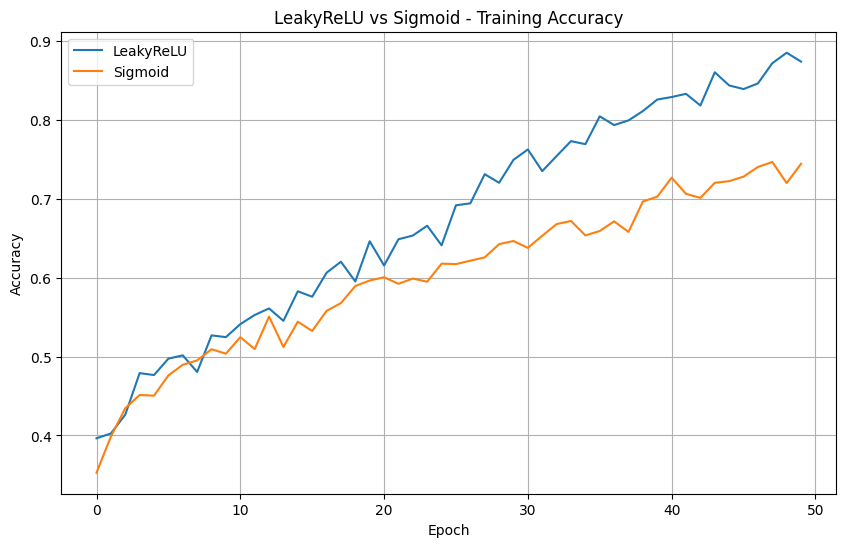

In [22]:
# Sigmoid를 사용하는 모델 정의
class ModelSigmoid(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.Sigmoid()  # Sigmoid 활성화 함수 사용

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)

        return x

# 모델 초기화 및 학습 (Sigmoid + Adam)
model_sigmoid = ModelSigmoid(input_dim, 1024).to(device)
optimizer_sigmoid = Adam(model_sigmoid.parameters(), lr=0.001)
train_accs_sigmoid = train_model(model_sigmoid, optimizer_sigmoid, n_epochs, trainloader, testloader, "Sigmoid Model")

# 결과 시각화 (Plot 2)
plot_acc({'LeakyReLU': train_accs_adam, 'Sigmoid': train_accs_sigmoid}, 'LeakyReLU vs Sigmoid - Training Accuracy')


Training model with dropout...
Epoch   1/50 | Loss: 378.9532 | Train Acc: 0.3694 | Test Acc: 0.3677
Epoch   5/50 | Loss: 298.8853 | Train Acc: 0.4609 | Test Acc: 0.4524
Epoch  10/50 | Loss: 272.5747 | Train Acc: 0.5095 | Test Acc: 0.4798
Epoch  15/50 | Loss: 252.4593 | Train Acc: 0.5737 | Test Acc: 0.5204
Epoch  20/50 | Loss: 233.9081 | Train Acc: 0.5951 | Test Acc: 0.5229
Epoch  25/50 | Loss: 216.8961 | Train Acc: 0.6207 | Test Acc: 0.5242
Epoch  30/50 | Loss: 201.9260 | Train Acc: 0.6625 | Test Acc: 0.5313
Epoch  35/50 | Loss: 187.2978 | Train Acc: 0.7153 | Test Acc: 0.5449
Epoch  40/50 | Loss: 172.2471 | Train Acc: 0.7485 | Test Acc: 0.5556
Epoch  45/50 | Loss: 157.3544 | Train Acc: 0.7600 | Test Acc: 0.5428
Epoch  50/50 | Loss: 145.9578 | Train Acc: 0.7735 | Test Acc: 0.5424


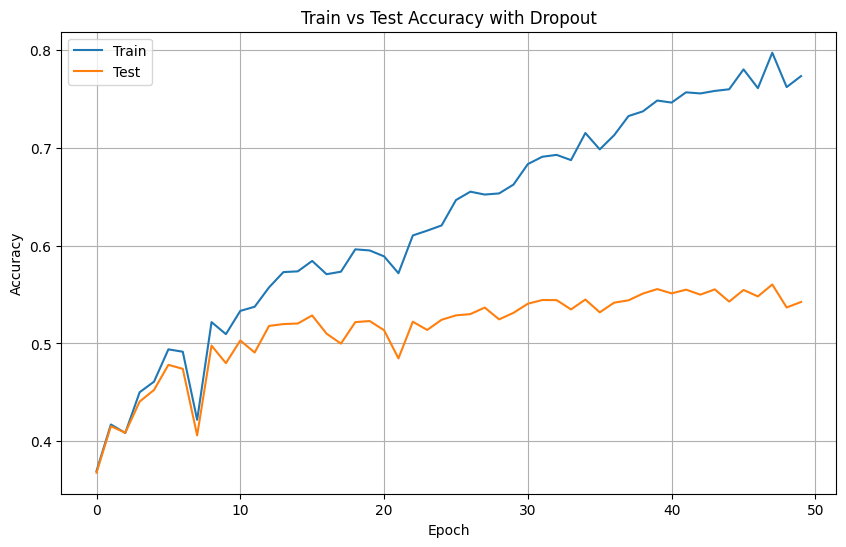

In [23]:
# Dropout을 적용한 모델 정의
class ModelDropout(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(p=0.1)  # Dropout 확률 0.1

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)

        return x

# Dropout 모델 학습 함수
def train_model_with_dropout(model, optimizer, n_epochs, trainloader, testloader):
    criterion = CrossEntropyLoss()
    train_accs = []
    test_accs = []
    
    print("Training model with dropout...")
    
    for epoch in range(n_epochs):
        # 학습 모드
        model.train()
        total_loss = 0.0
        
        for data in trainloader:
            optimizer.zero_grad()
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 매 에폭마다 정확도 측정
        with torch.no_grad():
            model.eval()  # 평가 모드로 설정
            train_acc = accuracy(model, trainloader)
            test_acc = accuracy(model, testloader)
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{n_epochs} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return train_accs, test_accs

# 모델 초기화 및 학습 (Dropout + Adam)
model_dropout = ModelDropout(input_dim, 1024).to(device)
optimizer_dropout = Adam(model_dropout.parameters(), lr=0.001)
train_accs_dropout, test_accs_dropout = train_model_with_dropout(model_dropout, optimizer_dropout, n_epochs, trainloader, testloader)

# 결과 시각화 (Plot 3)
plot_acc({'Train': train_accs_dropout, 'Test': test_accs_dropout}, 'Train vs Test Accuracy with Dropout')


최종 훈련 정확도 비교:
SGD + LeakyReLU: 0.3388
Adam + LeakyReLU: 0.8737
Adam + Sigmoid: 0.7442
Adam + LeakyReLU + Dropout (Train): 0.7735
Adam + LeakyReLU + Dropout (Test): 0.5424


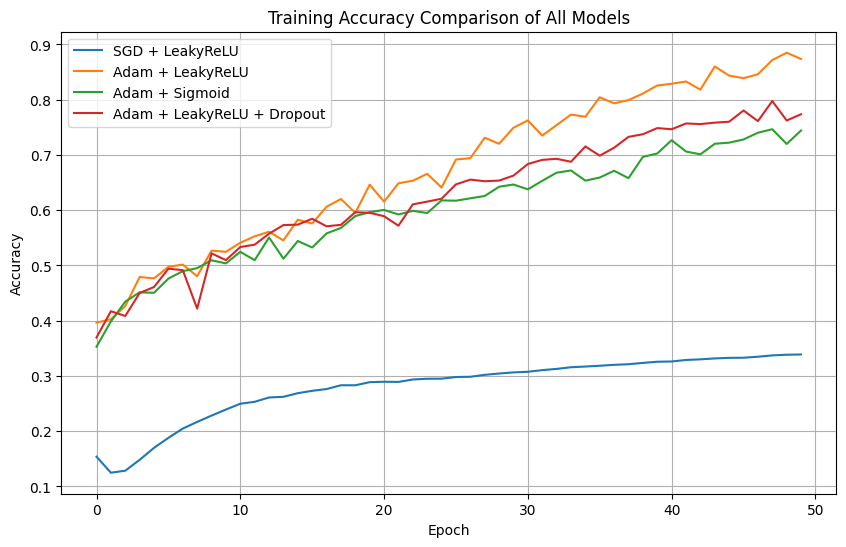

In [24]:
# 모든 모델의 최종 정확도 비교
print("\n최종 훈련 정확도 비교:")
print(f"SGD + LeakyReLU: {train_accs_sgd[-1]:.4f}")
print(f"Adam + LeakyReLU: {train_accs_adam[-1]:.4f}")
print(f"Adam + Sigmoid: {train_accs_sigmoid[-1]:.4f}")
print(f"Adam + LeakyReLU + Dropout (Train): {train_accs_dropout[-1]:.4f}")
print(f"Adam + LeakyReLU + Dropout (Test): {test_accs_dropout[-1]:.4f}")

# 모든 모델의 훈련 정확도 비교 시각화
plot_acc({
    'SGD + LeakyReLU': train_accs_sgd,
    'Adam + LeakyReLU': train_accs_adam,
    'Adam + Sigmoid': train_accs_sigmoid,
    'Adam + LeakyReLU + Dropout': train_accs_dropout
}, 'Training Accuracy Comparison of All Models')